# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


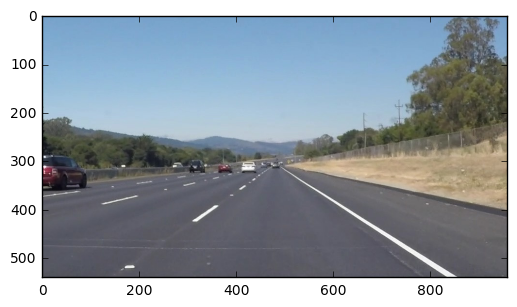

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
# Step 1: Detect segments on a single image

def detect_seg(frame):
    #grayscale
    gray = grayscale(frame)
    
    x_end = gray.shape[1] #960
    y_end = gray.shape[0] #540
    
    # Gaussian blur
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    
    # Edge contours
    low_threshold = 50
    high_threshold =150
    
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Marked region
    horizon_line = 320
    vertices = np.array([[(55,y_end),(450,horizon_line),(490,horizon_line),(x_end,y_end)]], dtype = np.int32)
    marked_region = region_of_interest(edges,vertices)
    
    
    # Lines
    line_edges =  hough_lines(marked_region, rho = 2, theta = np.pi/180,\
                             threshold = 10, min_line_len =50, \
                             max_line_gap = 20)
    
    frame = weighted_img(line_edges,frame)

    return frame

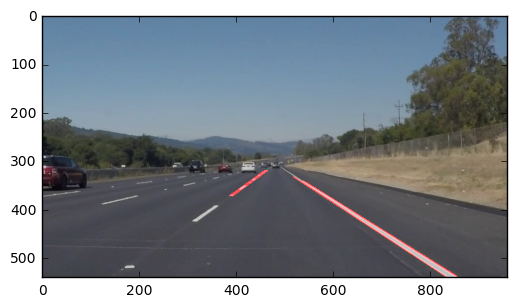

In [5]:
# Result of Step 2
plt.imshow(detect_seg(image))

 **  <p style="color:red;"> NOTE: First result  &quot; yellow_seg.mp4 &quot;  (wrt Critera II) - which is equivalent to the given video sample &quot; raw-lines-example.mp4 &quot;</p> **

In [6]:
# Test on video of segments lane detecction 

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result = detect_seg(image)
    return result

yellow_output_seg = 'yellow_seg.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output_seg, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output_seg))

[MoviePy] >>>> Building video yellow_seg.mp4
[MoviePy] Writing video yellow_seg.mp4


100%|█████████▉| 681/682 [00:55<00:00, 12.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow_seg.mp4 

CPU times: user 2min 27s, sys: 5.79 s, total: 2min 32s
Wall time: 56 s


In [7]:
# Step2:  Extrapolate lanes from the horizon to the base of frame 
def extrapo(x1, y1, x2, y2, horizon_line, frame_height):
    if x1 == x2:
        if y1 < y2:
            y1 = horizon_line
            y2 = frame_height
        else:
            y2 = horizon_line
            y1 = frame_height
    if y1 < y2:
        slope = (y2-y1)/(x2-x1)
        x1 = ((horizon_line-y1)/slope)+ x1
        y1 = horizon_line
        x2 = ((frame_height-y2)/slope) + x2
        y2 = frame_height
    else:
        slope = (y2-y1)/(x2-x1)
        x2 = ((horizon_line-y2)/slope) + x2
        y2 = horizon_line
        x1 = ((frame_height - y1)/slope) + x1
        y1 = frame_height
    return x1, y1, x2, y2
        

In [8]:
#Step 3: Inital extend lane detection function
def detect(frame):
    #grayscale
    gray = grayscale(frame)
    
    x_end = gray.shape[1] #960
    y_end = gray.shape[0] #540
    
    # Gaussian blur
    kernel_size = 3
    blur_gray = gaussian_blur(gray,kernel_size)
    
    # Edge contours
    low_threshold = 50
    high_threshold =150
    
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Marked region
    horizon_line = 0.6*y_end
    vertices = np.array([[(0,y_end),(x_end/2-20,horizon_line),(x_end/2+20,horizon_line),(x_end,y_end)]], dtype = np.int32)
    marked_region = region_of_interest(edges,vertices)
    
    
    # Lines
    line_edges =  cv2.HoughLinesP(marked_region, rho = 2, theta = np.pi/180,\
                             threshold = 10, minLineLength =45, \
                             maxLineGap = 20)
   
    # Set up a slope threshold to filter useless lines
    #min_slope = abs((y_end - horizon_line)*2/x_end)
    min_theta = 0.45
    
    #plt.imshow(line_edges)
    if line_edges is not None:
        left_bound = None #left-most of right line
        right_bound = None #right_most of left line
        dist1 = x_end / 2 # centre line of frame x = x_end
        dist2 = x_end / 2
        for line in line_edges:
            for x1, y1, x2, y2 in line:
                slope = (y2-y1)/(x2-x1)
                theta = np.abs(np.arctan2((y2-y1),(x2-x1)))
                if theta > min_theta:
                    if slope > 0: # right lane
                        dist = x1+(y_end-y1)/(y2-y1)*(x2-x1)-x_end/2 #baseline y= y_end, dist between centra frame & right lane
                        if dist < dist1:
                            right_bound = (x1, y1, x2, y2)
                            dist1 = dist
                    if slope < 0:
                        dist = x_end/2 - x1 - (y_end-y1)/(y2-y1)*(x2-x1) 
                        if dist < dist2:
                            left_bound = (x1, y1, x2, y2)
                            dist2 = dist
        line_img = np.zeros((*gray.shape,3), dtype=np.uint8)
        
        if left_bound is not None:
            left_bound = extrapo(left_bound[0], left_bound[1], left_bound[2], left_bound[3], horizon_line, y_end)
            left_bound = list(map(int,left_bound))
            cv2.line(line_img, (left_bound[0],left_bound[1]), (left_bound[2], left_bound[3]), [255,0,0], 8)

        if right_bound is not None:
            right_bound = extrapo(right_bound[0], right_bound[1], right_bound[2], right_bound[3], horizon_line, y_end)
            right_bound = list(map(int, right_bound))
            cv2.line(line_img, (right_bound[0],right_bound[1]), (right_bound[2], right_bound[3]), [255,0,0], 12)
        
        frame = weighted_img(line_img,frame)
        return frame

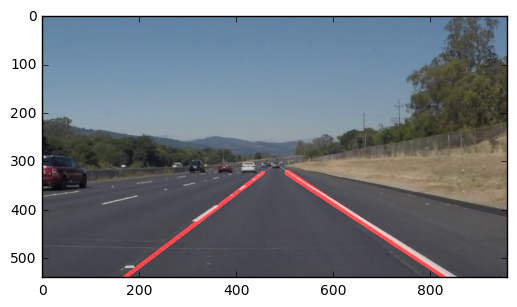

In [10]:
# Step 4: Test on sigle image & result
plt.imshow(detect(image))

In [11]:
import os
files = os.listdir("test_images/")

newpath = "./test_images_copy/" 
if not os.path.exists(newpath):
    os.makedirs(newpath)
print(newpath)

./test_images_copy/


In [13]:
# Step 5: Run on all test_image and save results
for pic in files:
    frame = mpimg.imread("test_images/"+pic)
    lanes = detect(frame)
    filename = pic[:-4]+'_copy'+'.jpg'
    cv2.imwrite(newpath+filename,lanes)

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detect(image)
    return result

Let's try the one with the solid white lane on the right first ...

 **  <p style="color:red;"> NOTE: Second result wrt Critera III - connect/extrapolate lane segments together;</p> **

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:17<00:00, 12.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 43 s, sys: 1.98 s, total: 44.9 s
Wall time: 18.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:55<00:00, 12.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min 26s, sys: 5.7 s, total: 2min 32s
Wall time: 56.7 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


 ### **  <p style="color:red;">REFRLECTIONS</p> **
## 1. Pipleline
<p>Step1: Grayscale</p>
<p>Step2: Gauss filter</p>
<p>Step3: Canny detection</p>
<p>Step4: Set regions by a horizon line and a minimum slope wrt this horizon line</p>
<p>Step5: Devide left/right line according to the slope value (positive/negative sign)</p>
<p>Step6: Get the most right bound from left lines group; get most left bound from right lines group</p>
<p>Step7: Scale the line accroding to the bound in fixed regions</p>

## 2. How to improve
- How to improve the robustness ?
 - Get desired slope from candidate line edges, in particular for curve lanes
     - In my case, the lane is not very continous cause the bound of lane changes a lot. A better way is to get a mean slope from left/right line group to keep smoomthness from frame to frame. But my way to get bound is still useful, because in real driving, we mostly consider the lane inner bound. 
 - Reduce the perspective effect of frame
     - The perspective effect means that in the video, lanes appear to converge in horizontal line. In fact, the horizontla line is tricky to select 
 - Filter the illumination disturbance (ex. shadows in challenge video)
     - In the challegne video, it's obvious that if there are shadows, the algorithm does not work well. It seems difficult to solve this disturbation from the point of changing filter (gaussian, median). Maybe tracking method, or other filter way ? I'm not sure

## 3. Conclusion

The marked-region based lane detection is useful to the straight lane but not very suitable for a cuve lane. The region of interst is tricky to define. At the same time, the parameters in the function cv2.HoughLineP asks for trial and errors, mainly setting minLineLength of about 20~30% of the total line length, maxLineGap between 5~10% of the expected total line length.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:34<00:00,  6.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 26s, sys: 3.54 s, total: 1min 29s
Wall time: 36.8 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))